In [1]:
from lxml import etree
import pandas as pd
import tablescraper as scraper
import re

In [2]:
# the-numbers.com is protected, you need to execute JS to load it.
# instead of scraping with selenium for just one page, I simply downloaded the budgets html file in Chrome
# (it messed up Firefox, crashes on viewing source...)
# 
# from http://www.the-numbers.com/movie/budgets/all -> the_numbers_movie_budgets_all.html

parser = etree.HTMLParser()

tree = etree.parse('the_numbers_movie_budgets_all.html', 
    base_url="http://www.the-numbers.com/movie/budgets/all",
    parser=parser)

tables = tree.xpath('//table')
print len(tables)

2


In [3]:
for tbl in tables:
    print '\n\n...\n\n'
    print scraper.html_to_string(tbl)[:200]



...


<table>
<tr><th>&#160;</th><th>Release Date</th><th>Movie</th><th>Production Budget</th><th>Domestic Gross</th><th>Worldwide Gross</th></tr>
<tr><td class="data">1</td>
<td><a href="/box-office-chart/


...


<table>
      <tr>
		 <input type="text" name="searchterm" value="" size="36" onkeyup="if (event.keyCode == 13) { this.form.submit(); return false; }"/>
      </tr>
     </table>
   


In [4]:
dfs = pd.read_html(scraper.html_to_string(tables[0]), match='', header=0)
len(dfs)

1

In [5]:
df = dfs[0]
print 'got %i rows' % len(df)
df.head()

got 5117 rows


,Unnamed: 0,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,1,12/18/2009,Avatar,"$425,000,000","$760,507,625","$2,783,918,982"
1,2,12/18/2015,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$935,642,689","$2,057,642,689"
2,3,5/24/2007,Pirates of the Caribbean: At World's End,"$300,000,000","$309,420,425","$963,420,425"
3,4,11/6/2015,Spectre,"$300,000,000","$200,074,175","$879,620,923"
4,5,7/20/2012,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099"


In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,12/18/2009,Avatar,"$425,000,000","$760,507,625","$2,783,918,982"
1,12/18/2015,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$935,642,689","$2,057,642,689"
2,5/24/2007,Pirates of the Caribbean: At World's End,"$300,000,000","$309,420,425","$963,420,425"
3,11/6/2015,Spectre,"$300,000,000","$200,074,175","$879,620,923"
4,7/20/2012,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099"


In [7]:
df.columns = [col.lower().replace(' ','_') for col in df.columns]
df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,12/18/2009,Avatar,"$425,000,000","$760,507,625","$2,783,918,982"
1,12/18/2015,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$935,642,689","$2,057,642,689"
2,5/24/2007,Pirates of the Caribbean: At World's End,"$300,000,000","$309,420,425","$963,420,425"
3,11/6/2015,Spectre,"$300,000,000","$200,074,175","$879,620,923"
4,7/20/2012,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099"


In [8]:
# reformat string columns to more useful dtypes
for col in ['production_budget','domestic_gross','worldwide_gross']:
    df[col] = pd.to_numeric(df[col].replace('[\$,]','',regex=True))

df.release_date = pd.to_datetime(df.release_date)

# make this for the join later
df['release'] = df.release_date.dt.year

df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release
0,2009-12-18,Avatar,425000000,760507625,2783918982,2009
1,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,935642689,2057642689,2015
2,2007-05-24,Pirates of the Caribbean: At World's End,300000000,309420425,963420425,2007
3,2015-11-06,Spectre,300000000,200074175,879620923,2015
4,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,2012


In [14]:
# Enable to save pickle
#######################

# df.to_pickle('movie_budgets.pickle')

/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


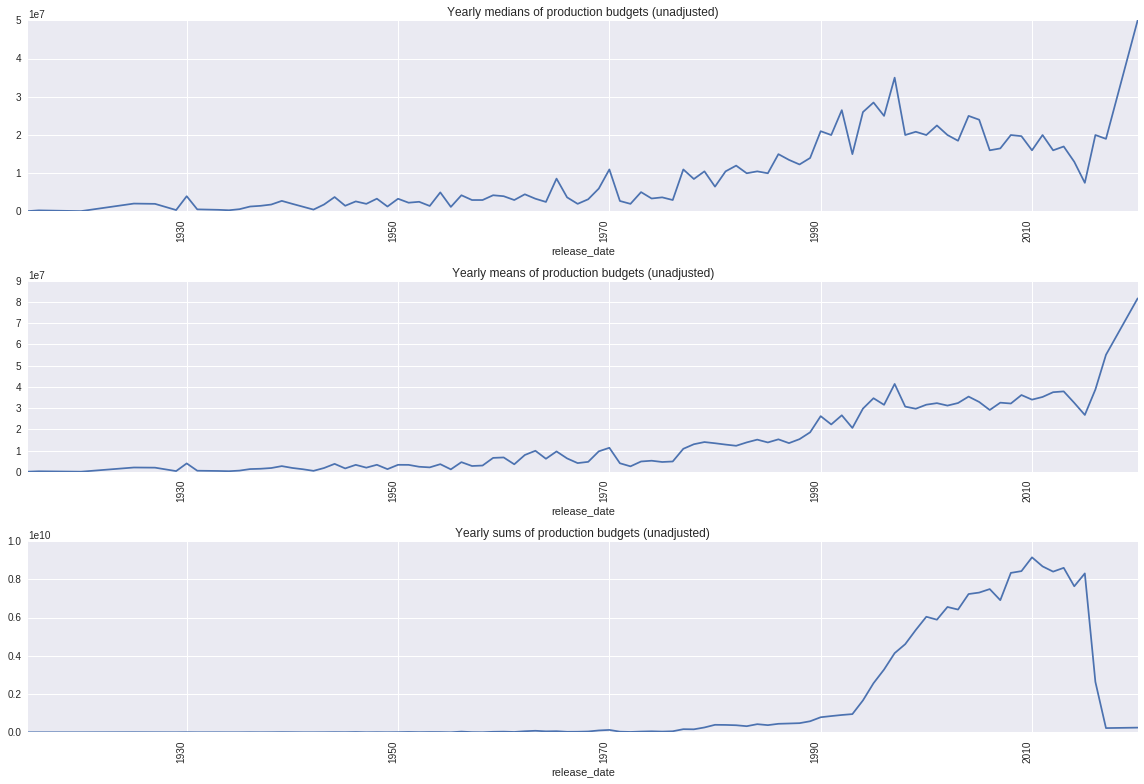

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

# 'AS' is start of year frequency
how_fns = ['median','mean','sum']

fig, axes = plt.subplots(nrows=len(how_fns), ncols=1)

for idx, how in enumerate(how_fns):
    yearly_df = df.set_index('release_date').resample('AS', how=how).dropna()
    yearly_df.production_budget.plot(
        title='Yearly %ss of production budgets (unadjusted)' % how, 
        ax=axes[idx], rot=90)

fig.tight_layout(rect=(0,0,2,2));

# Join the movie budget data with the actor data

In [15]:
actor_df = pd.read_pickle('actor_full.pickle').reset_index().rename(
    columns={'index':'actor','title':'movie'})

# Remove release date from movie title.
# 'Alice (2003)' -> 'Alice'
# trailing_year_in_parens = r'\ *\([0-9]*\)$'
trailing_year_in_parens = r' \([\s\w]+\)$'
actor_df.movie.replace(trailing_year_in_parens, value='', regex=True, inplace=True)

# 'release' column is by year, 'release_day' preserves the day
actor_df['release_day'] = actor_df.release.copy()
actor_df.release = actor_df.release.dt.year

actor_df.set_index(['movie','release'],inplace=True)

actor_df.head()

,,actor,rank,studio,adjusted_gross,unadjusted_gross,actor_id,Canadian male voice actors,21st-century Australian actresses,Canadian male television actors,English people of Irish descent,...,Best Miniseries or Television Movie Actor Golden Globe winners,British Shakespearean actresses,American television directors,American male child actors,Outstanding Performance by a Female Actor in a Miniseries or Television Movie Screen Actors Guild Award winners,Articles with unsourced statements from February 2016,Articles with unsourced statements from April 2016,male_txt,age_on_release,release_day
movie,release,,,,,,,,,,,,,,,,,,,,,
Spy,2015,50 Cent,1,Fox,116867700,110825712,50cent,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaT,2015-06-05
Southpaw,2015,50 Cent,2,Wein.,55265500,52421953,50cent,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaT,2015-07-24
Righteous Kill,2008,50 Cent,3,Over.,48566600,40081410,50cent,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaT,2008-09-12
Get Rich or Die Tryin',2005,50 Cent,4,Par.,42048300,30985352,50cent,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaT,2005-11-09
Escape Plan,2013,50 Cent,5,LG/S,26202200,25135965,50cent,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaT,2013-10-18


In [16]:
movie_df = df.copy()

movie_df.movie.replace(trailing_year_in_parens, value='', regex=True, inplace=True)

movie_df.set_index(['movie','release'], inplace=True)

movie_df.head()

,,release_date,production_budget,domestic_gross,worldwide_gross
movie,release,,,,
Avatar,2009,2009-12-18,425000000,760507625,2783918982
Star Wars Ep. VII: The Force Awakens,2015,2015-12-18,306000000,935642689,2057642689
Pirates of the Caribbean: At World's End,2007,2007-05-24,300000000,309420425,963420425
Spectre,2015,2015-11-06,300000000,200074175,879620923
The Dark Knight Rises,2012,2012-07-20,275000000,448139099,1084439099


In [17]:
joint_df = actor_df.join(movie_df)

# the more interesting columns for easy reading
readable_cols = ['actor','adjusted_gross','domestic_gross','production_budget']
joint_df[readable_cols].head()

actor  adjusted_gross  \
movie                release                                         
'71                  2015           Jack O'Connell         1332700   
'Night, Mother       1986            Anne Bancroft         1036200   
(500) Days of Summer 2009             Chloe Moretz        37749800   
                     2009              Clark Gregg        37749800   
                     2009     Joseph Gordon-Levitt        37749800   

                              domestic_gross  production_budget  
movie                release                                     
'71                  2015                NaN                NaN  
'Night, Mother       1986                NaN                NaN  
(500) Days of Summer 2009           32391374            7500000  
                     2009           32391374            7500000  
                     2009           32391374            7500000

In [18]:
# look at the NaN's from failed join
joint_df[joint_df.production_budget.isnull()][readable_cols].head()

actor  adjusted_gross  \
movie                  release                                    
'71                    2015      Jack O'Connell         1332700   
'Night, Mother         1986       Anne Bancroft         1036200   
...And Justice for All 1979           Al Pacino       115422300   
                       1979     Craig T. Nelson       115422300   
10                     1979       Julie Andrews       259494000   

                                domestic_gross  production_budget  
movie                  release                                     
'71                    2015                NaN                NaN  
'Night, Mother         1986                NaN                NaN  
...And Justice for All 1979                NaN                NaN  
                       1979                NaN                NaN  
10                     1979                NaN                NaN

In [19]:
def check_in_index(df, substr, col='movie'):
    return [title for title in df.reset_index()[col].unique() if substr in title]

In [20]:
check_in_index(movie_df, '(')

['(500) Days of Summer']

In [21]:
check_in_index(actor_df, '(')

['(500) Days of Summer',
 "Barney's Version (U.S. only)",
 'Sleeping Beauty (2011)',
 'The Passenger (re-issue)',
 'Eye See You (a.k.a. D-TOX)',
 'ABCD (Any Body Can Dance) 2',
 'Caravaggio (Re-issue)']

In [22]:
# num_of_nans = len(joint_df[joint_df.production_budget.isnull()][readable_cols])
# print num_of_nans, 'NaNs (failed joins) now...'
# print 6574 - num_of_nans, ' were fixed by regex on trailing parentheses'

In [23]:
pre_drop = len(joint_df)
joint_df.dropna(inplace=True)
joint_df.head()
print 'dropped %i rows, %i left' % (pre_drop-len(joint_df), len(joint_df))

joint_df.reset_index(inplace=True)

joint_df.head(20)

dropped 7075 rows, 9342 left


,movie,release,actor,rank,studio,adjusted_gross,unadjusted_gross,actor_id,Canadian male voice actors,21st-century Australian actresses,...,Outstanding Performance by a Female Actor in a Miniseries or Television Movie Screen Actors Guild Award winners,Articles with unsourced statements from February 2016,Articles with unsourced statements from April 2016,male_txt,age_on_release,release_day,release_date,production_budget,domestic_gross,worldwide_gross
0,(500) Days of Summer,2009,Chloe Moretz,11,FoxS,37749800,32391374,chloemoretz,False,False,...,False,False,False,0,4540 days,2009-07-17,2009-07-17,7500000,32391374,59101642
1,(500) Days of Summer,2009,Clark Gregg,7,FoxS,37749800,32391374,clarkgregg,False,False,...,False,False,False,1,17273 days,2009-07-17,2009-07-17,7500000,32391374,59101642
2,(500) Days of Summer,2009,Minka Kelly,-,FoxS,37749800,32391374,minkakelly,False,False,...,False,False,False,0,10615 days,2009-07-17,2009-07-17,7500000,32391374,59101642
3,(500) Days of Summer,2009,Zooey Deschanel,10,FoxS,37749800,32391374,zooeydeschanel,False,False,...,False,False,False,0,10774 days,2009-07-17,2009-07-17,7500000,32391374,59101642
4,10 Cloverfield Lane,2016,Mary Elizabeth Winstead,4,Par.,68379000,68378983,maryelizabethwinstead,False,False,...,False,False,False,0,11426 days,2016-03-11,2016-03-11,5000000,69793284,101493284
5,102 Dalmatians,2000,Glenn Close,7,BV,107144200,66957026,glennclose,False,False,...,True,False,False,0,19607 days,2000-11-22,2000-11-22,85000000,66941559,66941559
6,102 Dalmatians,2000,Ioan Gruffudd,4,BV,107144200,66957026,ioangruffudd,False,False,...,False,False,False,1,9909 days,2000-11-22,2000-11-22,85000000,66941559,66941559
7,10th & Wolf,2006,Giovanni Ribisi,25,Think,72700,54702,giovanniribisi,False,False,...,False,False,False,1,11567 days,2006-08-18,2006-08-18,8000000,54702,143782
8,10th & Wolf,2006,James Marsden,29,Think,72700,54702,jamesmarsden,False,False,...,False,False,False,1,12022 days,2006-08-18,2006-08-18,8000000,54702,143782
9,10th & Wolf,2006,Piper Perabo,14,Think,72700,54702,piperperabo,False,False,...,False,False,False,0,10883 days,2006-08-18,2006-08-18,8000000,54702,143782


In [24]:
# joint_df.to_pickle('joint_df.pickle')